In [1]:
from tapatan import *
from Game import *
from Game.minimax import *
from tqdm import tqdm

Version:  0.3.13


## Agents

In [2]:
def random_move(state,player):    
    moves=valid_moves(state,player)
    return random.choice(moves)

random_agent=Agent(random_move)

def human_move(state,player):
    print("Locations:")
    state.show_locations()
    print("Valid Moves:")
    print(valid_moves(state,player))
    
    while True:
        move=eval(input("Enter your move"))

        if move not in valid_moves(state,player):
            print("That is not a valid move")
        else:
            break
    
    return move

human_agent=Agent(human_move)

## Q Agent

In [3]:
def Q_move(state,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning

    if state in info.states:
        raise ValueError(str(state))
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ
    
    if state not in Q:
        actions=valid_moves(state,player)
        Q[state]=Table()
        for action in actions:
            Q[state][action]=0  # initial value of table
    
    if learning:
        if random.random()<ϵ:  # take a random move occasionally to explore the environment
            move=random_move(state,player)
        else:
            move=top_choice(Q[state])
    else:
        move=top_choice(Q[state])
    
    if not last_action is None:  # not the first move
        reward=0
        
        # learn
        if learning:
            Q[last_state][last_action]+=α*(reward +
                        γ*max([Q[state][a] for a in Q[state]]) - Q[last_state][last_action])        
    return move

In [4]:
def Q_after(status,player,info):
    Q=info.Q
    last_state=info.last_state
    last_action=info.last_action
    learning=info.learning
    
    α=info.α  # learning rate
    ϵ=info.ϵ  # how often to take a random move
    γ=info.γ  # memory constant -- how quickly does the table update back in time (earlier in the game)
    
    # \alpha <hit tab>    α
    # \epsilon <hit tab>  ϵ
    # \gamma <hit tab>    γ

    if status=='lose':
        reward=-1
    elif status=='win':
        reward=1
    elif status=='stalemate':
        reward=.5 # value stalemate a little closer to a win
    else:
        reward=0
    
    
    if learning:
        Q[last_state][last_action]+=α*(reward - Q[last_state][last_action])
        


In [5]:
Q1_agent=Agent(Q_move)
Q1_agent.post=Q_after
Q1_agent.Q=Table()  # makes an empty table
Q1_agent.learning=True

Q1_agent.α=0.2  # learning rate
Q1_agent.ϵ=0.3  # how often to take a random move
Q1_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

In [6]:
Q2_agent=Agent(Q_move)
Q2_agent.post=Q_after
Q2_agent.Q=Table()  # makes an empty table
Q2_agent.learning=True

Q2_agent.α=0.2  # learning rate
Q2_agent.ϵ=0.3  # how often to take a random move
Q2_agent.γ=0.9  # memory constant -- how quickly does the table update back in time (earlier in the game)

## Training

In [7]:
agent1=Q1_agent
agent1.Q=LoadTable("Q1_tapatan_table.json")
agent2=Q2_agent
agent2.Q=LoadTable("Q2_tapatan_table.json")

In [8]:
S=Storage()
one,two,ties,total_test,total_train=0,0,0,0,0

In [21]:
N_test=100
N_train=3000

In [22]:
for i in tqdm(range(2000)):
    Q1_agent.learning=True
    Q2_agent.learning=True
    g=Game(number_of_games=N_train)
    g.display=False
    g.check_repeated_states=True
    g.max_move_count=20
    result=g.run(agent1,agent2)

    
    Q1_agent.learning=False
    Q2_agent.learning=False
    g=Game(number_of_games=N_test)
    g.display=False
    g.check_repeated_states=True
    g.max_move_count=20
    result=g.run(agent1,agent2)
    one,two,ties,total_test,total_train=one+result.count(1),two+result.count(2),ties+result.count(0),total_test+N_test,total_train+N_train
    
    S+=one/total_test*100,two/total_test*100,ties/total_test*100,total_test,total_train


100%|███████████████████████████████████████████████████| 2000/2000 [1:34:50<00:00,  2.85s/it]


## Progress

In [23]:
y1,y2,y0,x1,x=S.arrays()

In [24]:
%matplotlib inline
from matplotlib.pyplot import figure,plot,grid,legend,xlabel,ylabel,title

Text(0, 0.5, 'Percent')

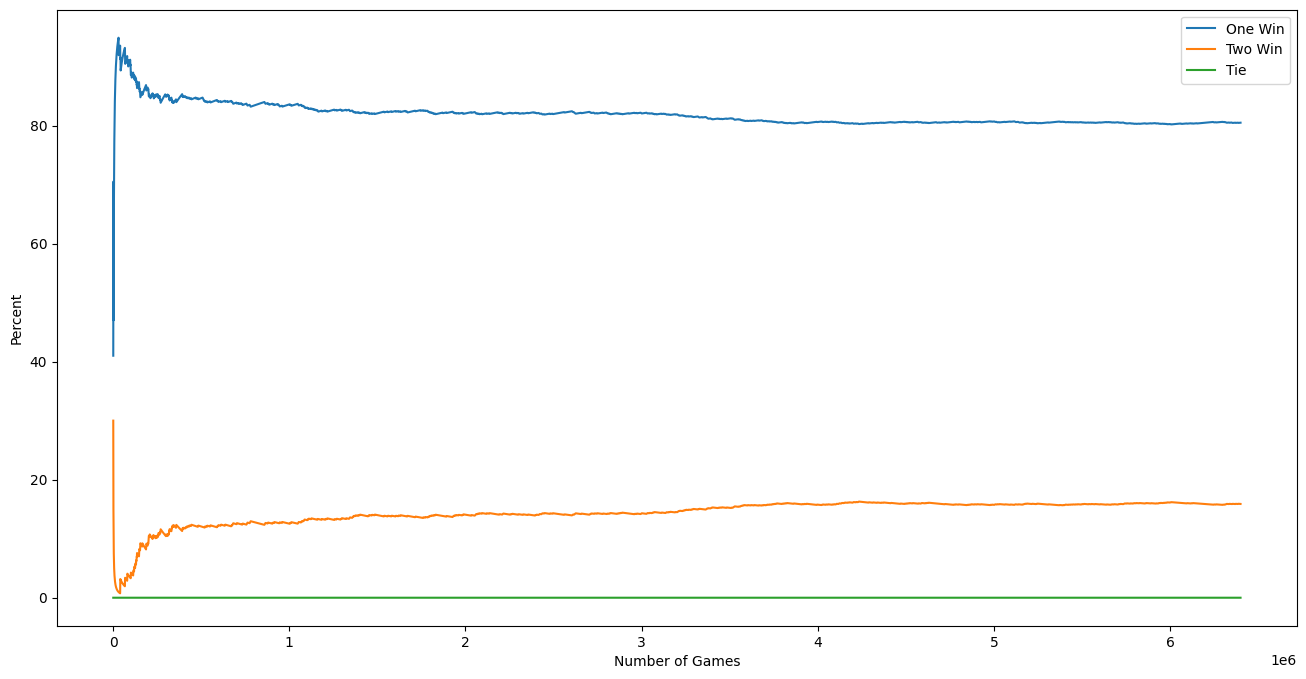

In [25]:
figure(figsize=(16,8))
plot(x,y1,label='One Win')
plot(x,y2,label='Two Win')
plot(x,y0,label='Tie')
legend()
xlabel('Number of Games')
ylabel('Percent')

In [26]:
SaveTable(Q1_agent.Q,"Q1_tapatan_table.json")
SaveTable(Q2_agent.Q,"Q2_tapatan_table.json")

In [27]:
g=Game()
g.run(Q1_agent,human_agent)

====
Game  1
 0  0  0 
 0  0  0 
 0  0  0 

Player 1 moves 1
 0  1  0 
 0  0  0 
 0  0  0 

Locations:
 0  1  2 
 3  4  5 
 6  7  8 

Valid Moves:
[0, 2, 3, 4, 5, 6, 7, 8]


Enter your move 4


Player 2 moves 4
 0  1  0 
 0  2  0 
 0  0  0 

Player 1 moves 0
 1  1  0 
 0  2  0 
 0  0  0 

Locations:
 0  1  2 
 3  4  5 
 6  7  8 

Valid Moves:
[2, 3, 5, 6, 7, 8]


Enter your move 2


Player 2 moves 2
 1  1  2 
 0  2  0 
 0  0  0 

Player 1 moves 6
 1  1  2 
 0  2  0 
 1  0  0 

Locations:
 0  1  2 
 3  4  5 
 6  7  8 

Valid Moves:
[3, 5, 7, 8]


Enter your move 3


Player 2 moves 3
 1  1  2 
 2  2  0 
 1  0  0 

Player 1 moves [1, 5]
 1  0  2 
 2  2  1 
 1  0  0 

Locations:
 0  1  2 
 3  4  5 
 6  7  8 

Valid Moves:
[[2, 1], [3, 1], [3, 7], [4, 1], [4, 7], [4, 8]]


Enter your move [4,1]


Player 2 moves [4, 1]
 1  2  2 
 2  0  1 
 1  0  0 

Player 1 moves [6, 4]
 1  2  2 
 2  1  1 
 0  0  0 

Locations:
 0  1  2 
 3  4  5 
 6  7  8 

Valid Moves:
[[3, 6], [3, 7]]


Enter your move [3,6]


Player 2 moves [3, 6]
 1  2  2 
 0  1  1 
 2  0  0 

Player 1 moves [5, 8]
 1  2  2 
 0  1  0 
 2  0  1 

Player  1 won.


[1]

In [16]:
# g=Game()
# g.run(human_agent,Q2_agent)